# Regress Out Tutorial

Author: [Yiming Yang](https://github.com/yihming), [Rimte Rocher](https://github.com/rocherr)<br />
Date: 2022-03-08<br />
Notebook Source: [regress_out.ipynb](https://raw.githubusercontent.com/klarman-cell-observatory/pegasus/master/notebooks/regress_out.ipynb)

This tutorial shows how to regress out cell cycle using Pegasus. To benchmark the work analogous to [Seurat's tutorial](https://satijalab.org/seurat/v3.2/cell_cycle_vignette.html) and [SCANPY's tutorial](https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb), we use the same dataset of murine hematopoietic progenitors from [[Nestorowa et al., Blood 2016]](https://doi.org/10.1182/blood-2016-05-716480), which can be downloaded [here](https://www.dropbox.com/s/3dby3bjsaf5arrw/cell_cycle_vignette_files.zip?dl=1).

## Cell-Cycle Scores

First, load the data:

In [1]:
import pegasus as pg

data = pg.read_input("nestorawa_forcellcycle_expressionMatrix.txt")
data

2022-03-08 14:25:26,040 - pegasusio.readwrite - INFO - tsv file 'nestorawa_forcellcycle_expressionMatrix.txt' is loaded.
2022-03-08 14:25:26,041 - pegasusio.readwrite - INFO - Function 'read_input' finished in 2.76s.


MultimodalData object with 1 UnimodalData: 'unknown-rna'
    It currently binds to UnimodalData object unknown-rna

UnimodalData object with n_obs x n_vars = 773 x 24193
    Genome: unknown; Modality: rna
    It contains 1 matrix: 'X'
    It currently binds to matrix 'X' as X

    uns: 'genome', 'modality'

We need to do some preprocessing work before calculating the cell-cycle scores:

In [2]:
pg.qc_metrics(data, min_genes=0, max_genes=1e5)
pg.filter_data(data)
pg.identify_robust_genes(data)
pg.log_norm(data, norm_count=1e4)

2022-03-08 14:25:26,173 - pegasusio.qc_utils - INFO - After filtration, 773 out of 773 cell barcodes are kept in UnimodalData object unknown-rna.
2022-03-08 14:25:26,174 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.08s.
2022-03-08 14:25:26,327 - pegasus.tools.preprocessing - INFO - After filtration, 24158/24193 genes are kept. Among 24158 genes, 24158 genes are robust.
2022-03-08 14:25:26,328 - pegasus.tools.preprocessing - INFO - Function 'identify_robust_genes' finished in 0.15s.
2022-03-08 14:25:26,439 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.11s.


To be consistent with Seurat's tutorial, the filtration threshold on number of genes is set to be large enough to avoid removing any cell barcode, and a normalization of TP10k (transcripts per 10k) is performed.

Now calculate cell-cycle scores using `calc_signature_score` (see [here](https://pegasus.readthedocs.io/en/latest/api/pegasus.calc_signature_score.html) for its documentation):

In [3]:
pg.calc_signature_score(data, 'cell_cycle_human')

2022-03-08 14:25:26,481 - pegasus.tools.utils - INFO - Loaded signatures from GMT file /Users/yangy197/GitHub/pegasus/pegasus/data_files/cell_cycle_human.gmt.
2022-03-08 14:25:26,484 - pegasus.tools.signature_score - INFO - Signature G1/S: 42 out of 43 genes are used in signature score calculation.
2022-03-08 14:25:26,507 - pegasus.tools.signature_score - INFO - Signature G2/M: 52 out of 54 genes are used in signature score calculation.
2022-03-08 14:25:26,557 - pegasus.tools.signature_score - INFO - Function 'calc_signature_score' finished in 0.11s.


By setting `cell_cycle_human`, Pegasus uses the cell cycle genes defined in [[Tirosh et al. 2015]](https://science.sciencemag.org/content/352/6282/189) for calculation. We can fetch these genes from Pegasus pre-stored file (https://raw.githubusercontent.com/klarman-cell-observatory/pegasus/master/pegasus/data_files/cell_cycle_human.gmt), as we'll need them in the following sections:

In [4]:
cell_cycle_genes = []
with open("cell_cycle_human.gmt", 'r') as f:
    for line in f:
        cell_cycle_genes += line.strip().split('\t')[2:]

Moreover, the predicted phases of cells are stored in `data.obs` field with key `predicted_phase`:

In [5]:
data.obs['predicted_phase'].value_counts()

G0      346
G1/S    248
G2/M    179
Name: predicted_phase, dtype: int64

And the corresponding scores are in `data.obs['G1/S']` and `data.obs['G2/M']`.

## Cell Cycle Effects

The presence of cell cycle effects can be shown in terms of Principal Components (PC), which are calculated from gene-count matrix with respect to cell cycle genes:

In [6]:
data_cc_genes = data[:, cell_cycle_genes].copy()
pg.pca(data_cc_genes)
data.obsm['X_pca'] = data_cc_genes.obsm['X_pca']

2022-03-08 14:25:26,737 - pegasus.tools.preprocessing - INFO - Function 'pca' finished in 0.09s.


After achieving PCA result, we can generate a scatter plot of first two PCs with predicted phase being the colors for cells:

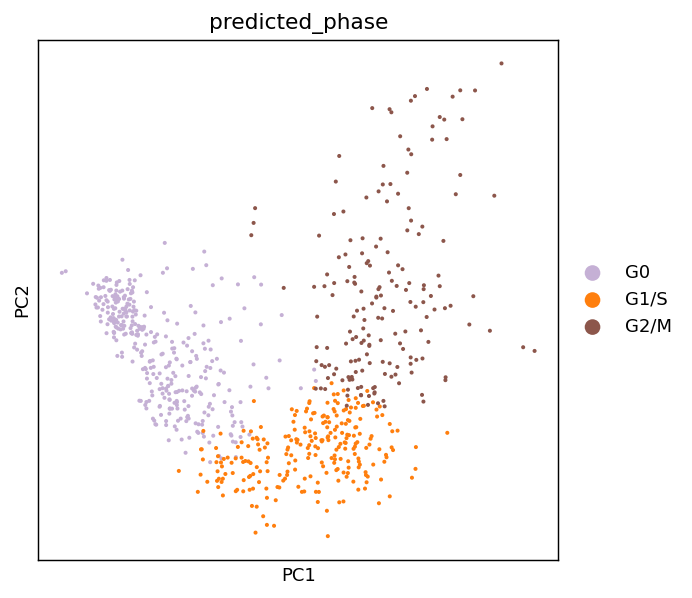

In [7]:
pg.scatter(data, attrs='predicted_phase', basis='pca', dpi=130)

In this plot, we can see that cells are quite separated due to their phases when cell cycle genes are considered.

## Regress Out Cell Cycle Effects

This section shows how to regress out cell cycle effects.

Pegasus performs this regressing out on PCs. After getting the original PCA matrix, it uses the cell-cycle scores for this operation:

In [8]:
pca_key = pg.regress_out(data, attrs=['G1/S', 'G2/M'])

2022-03-08 14:25:27,000 - pegasus.tools.preprocessing - INFO - Function 'regress_out' finished in 0.09s.


When `regress_out` is finished, the resulting new PCA embedding matrix is stored in `data.obsm['X_pca_regressed']`, with the representation key `'pca_regressed'` returned to variable `pca_key`.

Now let's see how PC scatter plot looks on the regressed-out components:

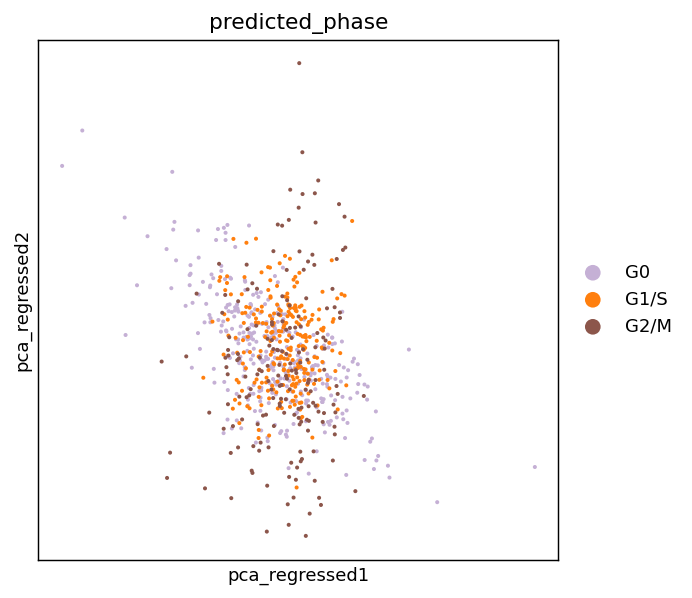

In [9]:
pg.scatter(data, attrs=['predicted_phase'], basis=pca_key, dpi=130)

You can see that after regressing out cell-cycle scores, no evident cell-cycle effects are observed in the first 2 PCs.

## Alternate Workflow

The alternative in this section simply mimics Seurat's way of regressing out the difference between the G2/M and G1/S phase scores. As stated in Seurat tutorial, in this way, we'll have differences in cell cycle phases regressed out, while the differences between non-cycling cells and cycling cells are maintained.

2022-03-08 14:25:27,268 - pegasus.tools.preprocessing - INFO - Function 'regress_out' finished in 0.09s.


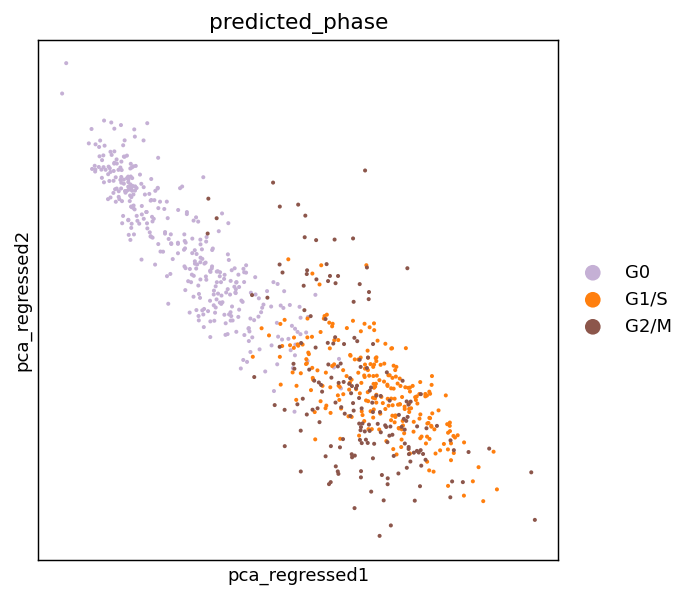

In [10]:
data_alt = data.copy()

data_alt.obs['CC_diff'] = data_alt.obs['G1/S'] - data_alt.obs['G2/M']
pca_key = pg.regress_out(data_alt, attrs=['CC_diff'])
pg.scatter(data_alt, attrs=['predicted_phase'], basis=pca_key, dpi=130)

## Summary

You can use the immediate result of `regress_out` function (i.e. `data.obsm['X_pca_regressed']`) for the downstream analysis (e.g. `pg.neighbors(data, rep='pca_regressed'); pg.louvain(data, rep='pca_regressed')`). Just remember to set the `basis` argument of the Pegasus functions whenever applicable.

The major difference between Pegasus' method and conventional method is that Pegasus performs regressing out on PCs, rather than all the features. For example, in this case, Pegasus only considers $50$ PCs, instead of all the $24,158$ features. Therefore, Pegasus method can be more efficient on large-scale datasets which contains many more cell barcodes.

## Matching with Seurat and SCANPY Tutorials

In sections above, we only show the scatter plots of first two of the regressed-out components. In order to match with the corresponding tutorials in Seurat and SCANPY, we further perform PCA on these components, and show the PC scatter plots in the newly computed PCs.

First is the result after regressing out the cell cycle effects based on G2/M and G1/S phase scores:

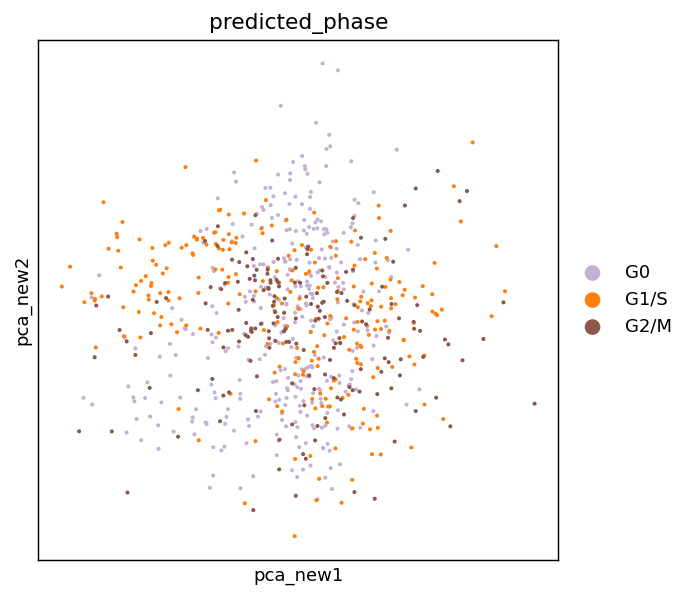

In [11]:
import numpy as np
from sklearn.decomposition import PCA

X = data.obsm['X_' + pca_key]
pca = PCA(n_components=X.shape[1], random_state=0, svd_solver='full')
X_pca_new = pca.fit_transform(X)
data.obsm['X_pca_new'] = np.ascontiguousarray(X_pca_new)

pg.scatter(data, attrs=['predicted_phase'], basis='pca_new', dpi=130)

So indeed, no evident cell-cycle effects are observed after regressing out.

Then the result of the alternative workflow, i.e. regressing out the difference between the G2/M and G1/S phase scores:

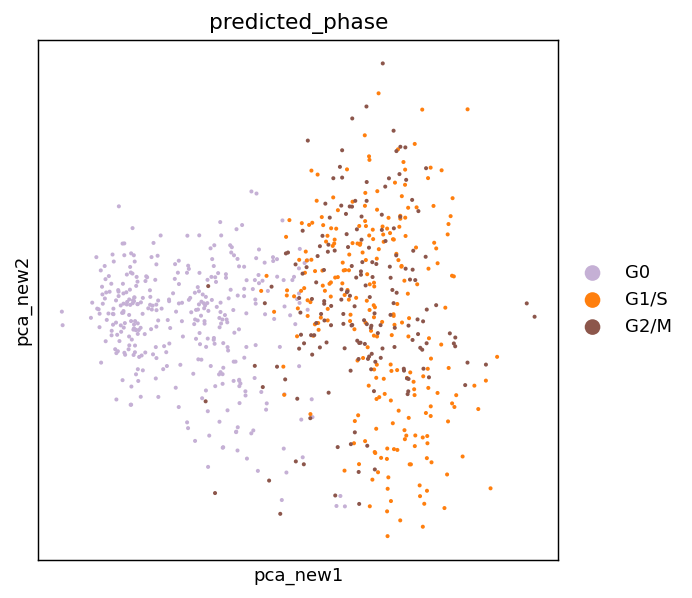

In [12]:
X = data_alt.obsm['X_' + pca_key]
pca = PCA(n_components=X.shape[1], random_state=0, svd_solver='full')
X_pca_new = pca.fit_transform(X)
data_alt.obsm['X_pca_new'] = np.ascontiguousarray(X_pca_new)

pg.scatter(data_alt, attrs=['predicted_phase'], basis='pca_new', dpi=130)

In the plot above, cells in G2/M and G1/S phases have a better mixture, while their difference from those in G0 phase is maintained.